<Body>   
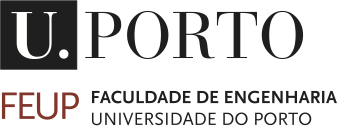   
<h1> <b>Machine Learning 2022/2023 </b> </h1>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---


Projeto Apredizagem Computacional 2022/2023

Alunos:   André de Azevedo Barata,
          Tiago Daniel Sousa,
          Renato Pedrosa de Jesus

Docentes: Jaime Cardoso,
          Andry Pinto

Título: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

# **Data Set**

 - O dataset é proveniente do kaggle e copiado para uma pasta do google drive.

 - São importados usando a bibloteca pandas e dando mount à google drive.

 - Para importar o ficheiro basta aceitar as permissões para dar mount na drive e alterar o caminho para os ficheiro que têm que estar na drive pessoal do utilizador

 - Mais informaçoes acerca do data set em data_description.txt na pasta projeto_APC->data_set

Para mais informações ver o link: https://www.tableau.com/learn/articles/what-is-data-cleaning


**Correr apenas uma das 4 linha abaixo, para dar import dos ficheiros**

In [ ]:
from google.colab import drive

#monta na drive para importar dataset
drive.mount('/content/drive/', force_remount = True)

### Alterar os caminhos para os ficheiros, pode copiar e colar o caminho selecionando, nas 3 barras no canto superior esquedo do colab,
#selecionar o icon da pasta -> Drive -> MyDrive -> <procurar pela localização do ficheiro> -> copy path
data_train_path = '/train.csv'
data_test_path = '/test.csv'
submission_path = '/sample_submission.csv'

Mounted at /content/drive/


##**Importar os dados**

In [ ]:
!pip install fancyimpute
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats
from pandas.core.reshape.reshape import get_dummies
from sklearn.preprocessing import OrdinalEncoder
from fancyimpute import KNN
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Os dados foram organizados como:
 - X_train - dados de treino
 - X_test - dados relativos ao teste.

Em X_train existe uma coluna chamada "SalePrice" que é o valor a prever, logo é guardada em y_train e retirada de X_train

Para tratar os dados, X_train e X_test são conctenados em X_fully e y_train e y_test em y_fully

In [ ]:
#import dataset train
X_train = pd.read_csv(data_train_path)
y_train = X_train[['Id', 'SalePrice']]
X_train = X_train.drop(['SalePrice'], axis=1)

#import dataset test
X_test = pd.read_csv(data_test_path)
y_test = pd.read_csv(submission_path)

#Save the dimenstion of data
#Guarda a dimensão (nº de linhas) dos dados de treino
train_dimention = X_train.shape[0]
test_dimention = X_test.shape[0]

#Junta X-train e X_test é possível separar com o seguinte código comentado abaixo
X_fully = pd.concat([X_train.assign(ind="train"), X_test.assign(ind="test")])
#X_train, X_test = X_fully[X_fully["ind"].eq("train")], X_fully[X_fully["ind"].eq("test")]

y_fully = pd.concat([y_train.assign(ind="train"), y_test.assign(ind="test")])
#y_train, y_test = y_fully[y_fully["ind"].eq("train")], y_fully[X_fully["ind"].eq("test")]

print('Input shape: ', X_fully.shape)

Input shape:  (2919, 81)


In [ ]:
X_fully.info()
#y_fully.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

Conclusões iniciais
- Os data type parecem bons
- Há imensos NA
- Pode haver casos que de valores numéricos que são categorias

In [ ]:
X_fully.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


##**Analise dos Dados**

### Colunas Categóricas

Nesta secção será feita a passagem das features do tipo objeto para tipo numérico e iremos lidar com os missing values.

Para este proedimento, baseamo-nos no seguinte site: https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa

In [ ]:
#retorna as features todas
def features_all(df):
  return df.columns

#retorna as features com missing values
def features_NA(df):
  return [features for features in df.columns if df[features].isnull().sum() > 1]

#Identifica features com valor nulo
def features_missing(df):
  #//features_NA = [features for features in X_fully.columns if X_fully[features].isnull().sum() > 1]
  print("Features with missing values:\n")
  for feature in features_NA(df):
    print(feature, np.round(df[feature].isnull().mean(), 2) * 100, '% valores em falta')

features_missing(X_fully)

Features with missing values:

MSZoning 0.0 % valores em falta
LotFrontage 17.0 % valores em falta
Alley 93.0 % valores em falta
Utilities 0.0 % valores em falta
MasVnrType 1.0 % valores em falta
MasVnrArea 1.0 % valores em falta
BsmtQual 3.0 % valores em falta
BsmtCond 3.0 % valores em falta
BsmtExposure 3.0 % valores em falta
BsmtFinType1 3.0 % valores em falta
BsmtFinType2 3.0 % valores em falta
BsmtFullBath 0.0 % valores em falta
BsmtHalfBath 0.0 % valores em falta
Functional 0.0 % valores em falta
FireplaceQu 49.0 % valores em falta
GarageType 5.0 % valores em falta
GarageYrBlt 5.0 % valores em falta
GarageFinish 5.0 % valores em falta
GarageQual 5.0 % valores em falta
GarageCond 5.0 % valores em falta
PoolQC 100.0 % valores em falta
Fence 80.0 % valores em falta
MiscFeature 96.0 % valores em falta


Existem features com demasiados missing values, por exemplo PoolQC com 100% (99,9...% na verdade) ou Alley com 93%. Tem que se lidar com este valores de forma diferente

Primeiro vamos tratar de passar as features do tipo objeto para tipo númerico, sem que deixem de ser categóricas
Para o efeito, usamos o encoder OriginalEnoder

Apenas foi feito o encode nos valores não nulos, ou seja, NA não conta como uma categoria

Informação do site: https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa

In [ ]:
#instantiate both packages to use
encoder = OrdinalEncoder()
imputer = KNN(k=10) #Vizinhos mais próximo com k=10 vizinhos

# Cria uma lista de features categóricas e outra com as numéricas
cat_cols = X_fully.select_dtypes(include=['object']).columns
num_cols = X_fully.select_dtypes(exclude=['object']).columns

#Função responsável pelo encode das APENAS das features categóricas não nulas
def encode(data):
    #contem os valores não nulos
    nonulls = np.array(data.dropna())

    #Reshape para ser possível dar encode
    impute_reshape = nonulls.reshape(-1,1)

    #encode data
    impute_ordinal = encoder.fit_transform(impute_reshape)

    #Realocar os valores
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data


#Faz encode, coluna a coluna, apenas das categóricas
for columns in cat_cols:
    encode(X_fully[columns])


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

### Valores em falta

Para lidar com os valores em falta usamos o método do vizinho mais próximo na maioria dos casos. Deste modo, é possível prever o valor que está em falta pela analise da proximidade com outras linhas. Por exemplo, se em 90% dos casos em que as colunas x, y, z têm o valor 1, w toma valor zero, caso o valor de 2 esteja em falta e x=y=z=1, é previsível que w = 0.

Esta comparação é feita aos k vizinhos mais próximos e atribuída a medias do k.

Estamos a utilizar o KNN do fancyimpute que por default usa k=5.

Nos casos em que mais de 80% dos valores estão em falta, definmos os missing values a zero, isto porque não há dados suficiente para prever o valor em falta

In [ ]:
threshold = 0.8 * len(X_fully.index)

for feature in X_fully:
  if X_fully[feature].isnull().count() > threshold:
    X_fully[feature].fillna(0)

#KNN, com k=10

#Para valores categórios é necessário arredondar
X_fully_encode = pd.DataFrame(np.round(imputer.fit_transform(X_fully)),columns = X_fully.columns)

Imputing row 1/2919 with 5 missing, elapsed time: 5.835
Imputing row 101/2919 with 5 missing, elapsed time: 5.860
Imputing row 201/2919 with 5 missing, elapsed time: 5.884
Imputing row 301/2919 with 4 missing, elapsed time: 5.907
Imputing row 401/2919 with 4 missing, elapsed time: 5.956
Imputing row 501/2919 with 5 missing, elapsed time: 6.022
Imputing row 601/2919 with 4 missing, elapsed time: 6.052
Imputing row 701/2919 with 4 missing, elapsed time: 6.082
Imputing row 801/2919 with 4 missing, elapsed time: 6.134
Imputing row 901/2919 with 6 missing, elapsed time: 6.158
Imputing row 1001/2919 with 10 missing, elapsed time: 6.181
Imputing row 1101/2919 with 5 missing, elapsed time: 6.204
Imputing row 1201/2919 with 4 missing, elapsed time: 6.266
Imputing row 1301/2919 with 5 missing, elapsed time: 6.307
Imputing row 1401/2919 with 4 missing, elapsed time: 6.354
Imputing row 1501/2919 with 6 missing, elapsed time: 6.393
Imputing row 1601/2919 with 5 missing, elapsed time: 6.416
Imputing

In [ ]:
X_fully.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind
0,1,60,3.0,65.0,8450,1.0,NaN,3.0,3.0,0.0,...,0,NaN,NaN,NaN,0,2,2008,8.0,4.0,1.0
1,2,20,3.0,80.0,9600,1.0,NaN,3.0,3.0,0.0,...,0,NaN,NaN,NaN,0,5,2007,8.0,4.0,1.0
2,3,60,3.0,68.0,11250,1.0,NaN,0.0,3.0,0.0,...,0,NaN,NaN,NaN,0,9,2008,8.0,4.0,1.0
3,4,70,3.0,60.0,9550,1.0,NaN,0.0,3.0,0.0,...,0,NaN,NaN,NaN,0,2,2006,8.0,0.0,1.0
4,5,60,3.0,84.0,14260,1.0,NaN,0.0,3.0,0.0,...,0,NaN,NaN,NaN,0,12,2008,8.0,4.0,1.0


In [ ]:
X_fully_encode.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,ind
0,1.0,60.0,3.0,65.0,8450.0,1.0,0.0,3.0,3.0,0.0,...,0.0,1.0,1.0,2.0,0.0,2.0,2008.0,8.0,4.0,1.0
1,2.0,20.0,3.0,80.0,9600.0,1.0,0.0,3.0,3.0,0.0,...,0.0,1.0,1.0,2.0,0.0,5.0,2007.0,8.0,4.0,1.0
2,3.0,60.0,3.0,68.0,11250.0,1.0,0.0,0.0,3.0,0.0,...,0.0,1.0,1.0,2.0,0.0,9.0,2008.0,8.0,4.0,1.0
3,4.0,70.0,3.0,60.0,9550.0,1.0,0.0,0.0,3.0,0.0,...,0.0,1.0,1.0,2.0,0.0,2.0,2006.0,8.0,0.0,1.0
4,5.0,60.0,3.0,84.0,14260.0,1.0,0.0,0.0,3.0,0.0,...,0.0,1.0,1.0,2.0,0.0,12.0,2008.0,8.0,4.0,1.0
5,6.0,50.0,3.0,85.0,14115.0,1.0,0.0,0.0,3.0,0.0,...,0.0,1.0,2.0,2.0,700.0,10.0,2009.0,8.0,4.0,1.0
6,7.0,20.0,3.0,75.0,10084.0,1.0,0.0,3.0,3.0,0.0,...,0.0,1.0,1.0,2.0,0.0,8.0,2007.0,8.0,4.0,1.0
7,8.0,60.0,3.0,86.0,10382.0,1.0,0.0,0.0,3.0,0.0,...,0.0,1.0,1.0,2.0,350.0,11.0,2009.0,8.0,4.0,1.0
8,9.0,50.0,4.0,51.0,6120.0,1.0,0.0,3.0,3.0,0.0,...,0.0,1.0,2.0,2.0,0.0,4.0,2008.0,8.0,0.0,1.0
9,10.0,190.0,3.0,50.0,7420.0,1.0,1.0,3.0,3.0,0.0,...,0.0,1.0,2.0,2.0,0.0,1.0,2008.0,8.0,4.0,1.0


Próximas quatro linhas servem para observar os resultados inerentes ao encode e à previsão dos missing values nas features categóricas

In [ ]:
#substituir pela feature categórica que querem testar
feature_test = "MSZoning"

print("Numero de missing antes do KNN:", X_fully[feature_test].isnull().sum(), "\n")
print("Lables antes do KNN:")
print(X_fully[feature_test].value_counts())
print("")
print("Lables após KNN:")
print(X_fully_encode[feature_test].value_counts())

Numero de missing antes do KNN: 4 

Lables antes do KNN:
3.0    2265
4.0     460
1.0     139
2.0      26
0.0      25
Name: MSZoning, dtype: int64

Lables após KNN:
3.0    2269
4.0     460
1.0     139
2.0      26
0.0      25
Name: MSZoning, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


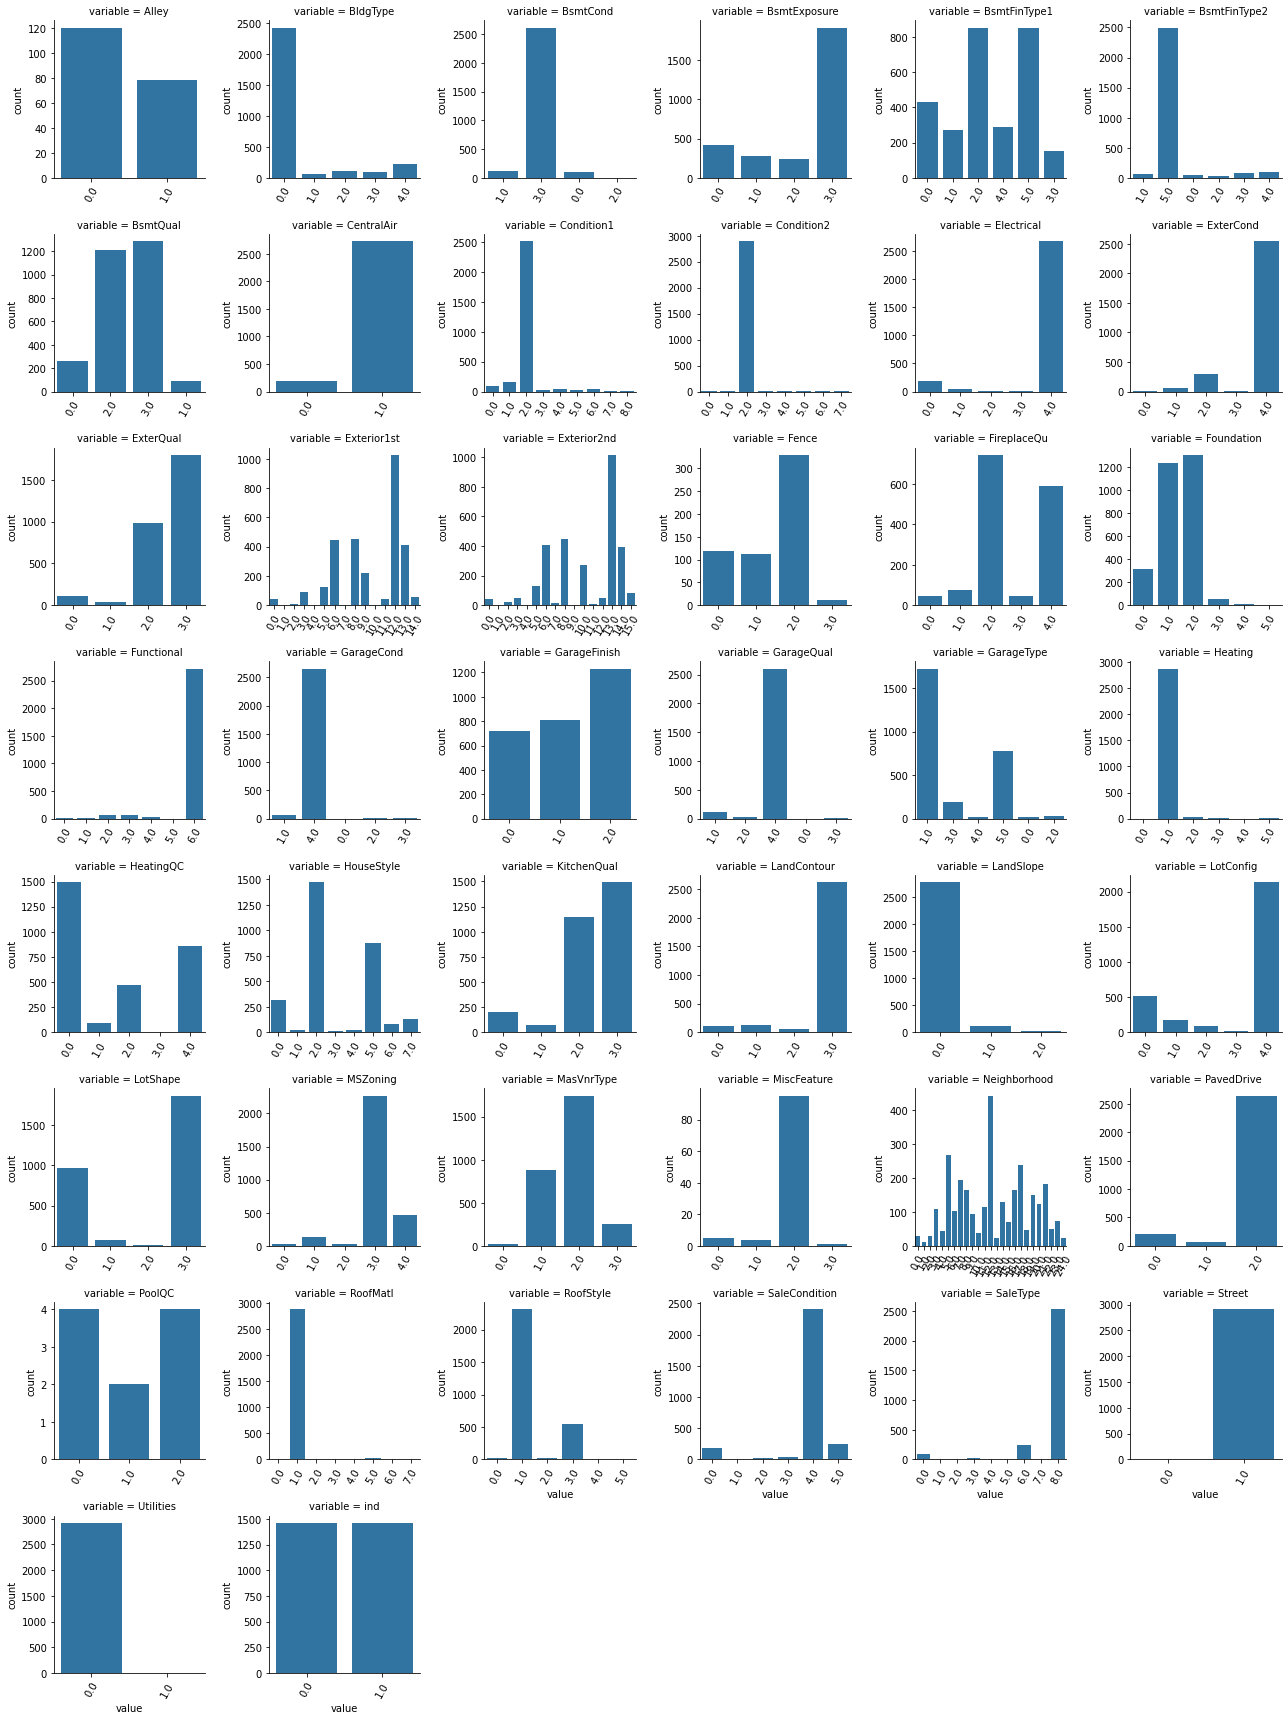

In [ ]:
#Função para dar plot das features catagóricas
def plot_catagorical_features(arg1):
  f=pd.melt(arg1,value_vars=sorted(arg1))
  g = sns. FacetGrid(f, col='variable', col_wrap=6, sharex=False, sharey=False)
  plt.xticks(rotation="vertical")
  g =g.map(sns.countplot,"value")
  [plt.setp(ax.get_xticklabels(),rotation=60) for ax in g.axes.flat]
  g.fig.tight_layout()
  plt.show()

data_to_plot = X_fully[cat_cols].copy()
plot_catagorical_features(data_to_plot)

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


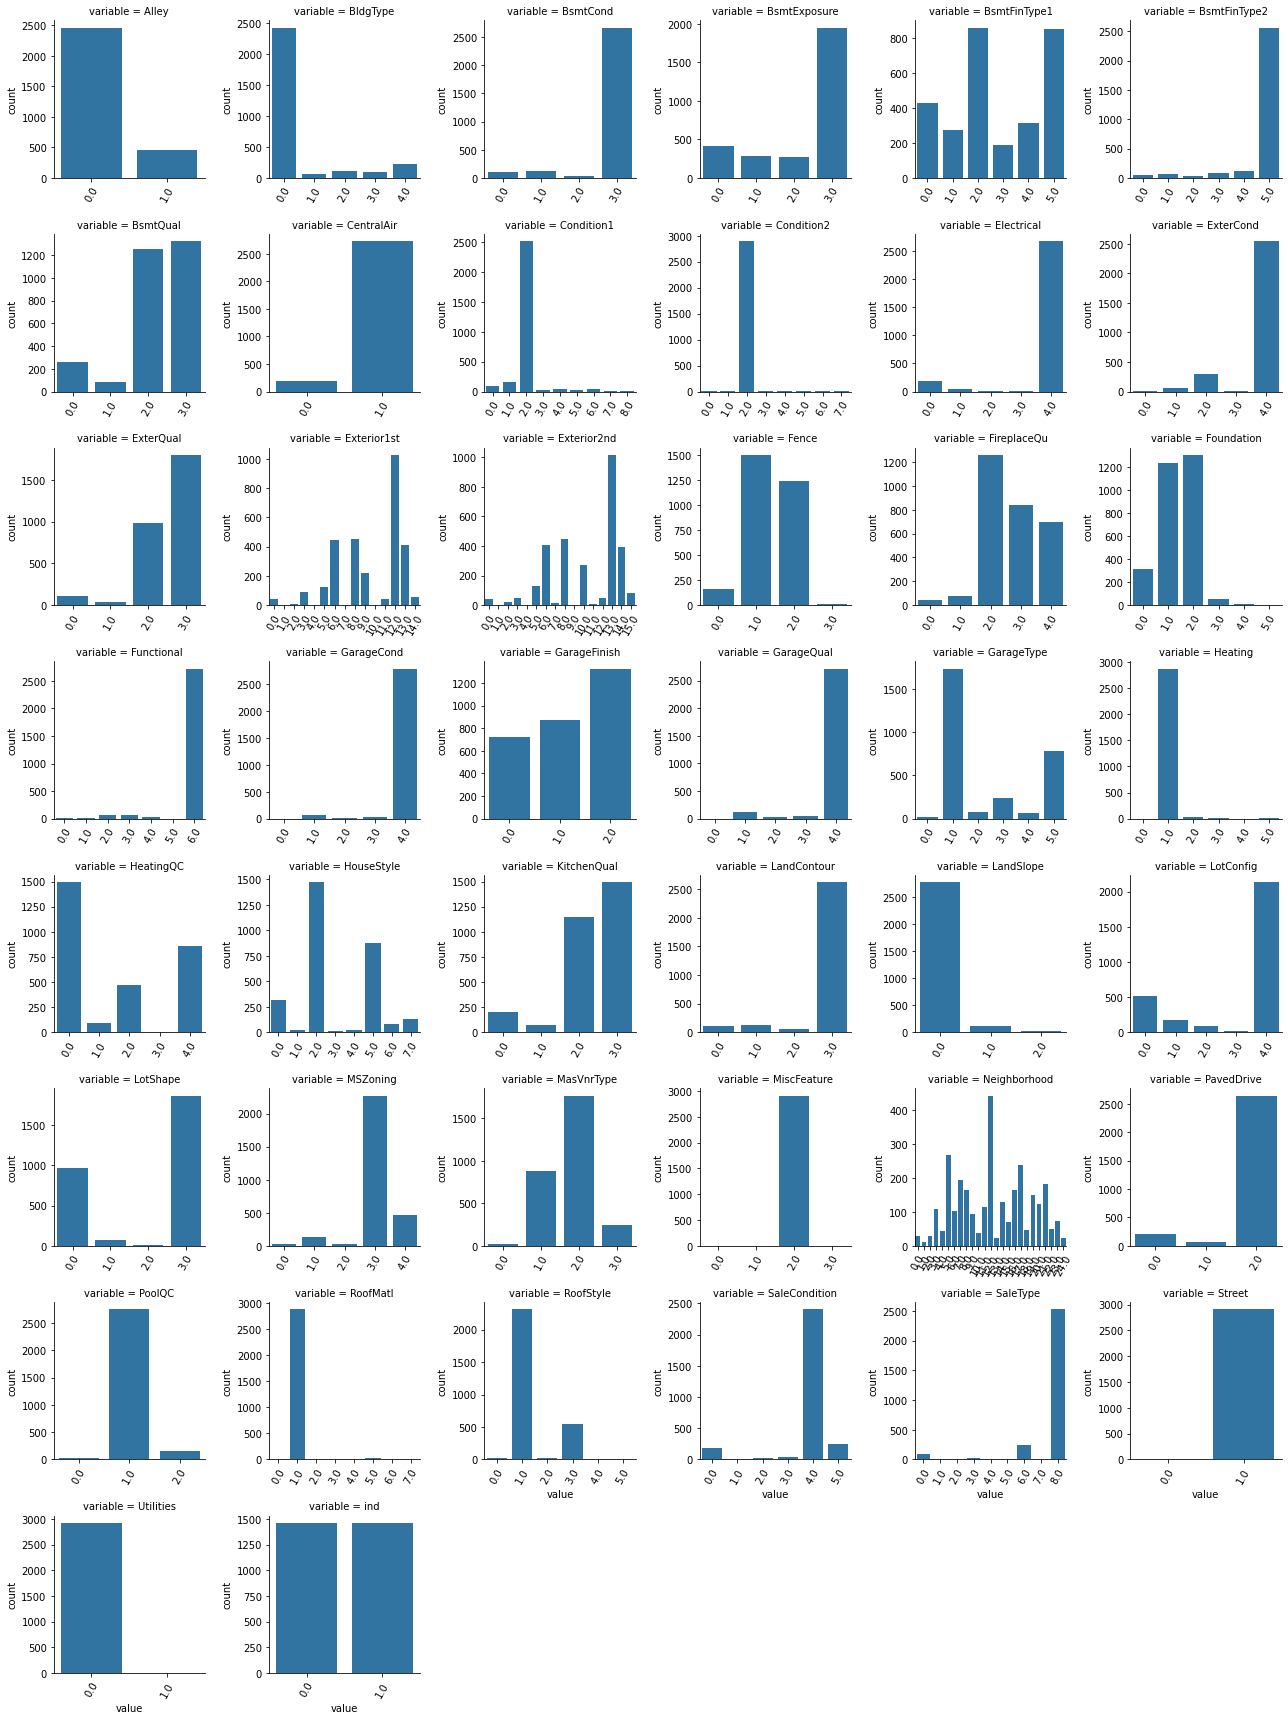

In [ ]:
data_to_plot = X_fully_encode[cat_cols].copy()
plot_catagorical_features(data_to_plot) #para verificar antes do encode substituir cat_X_objects_coded por cat_X_objects

### Verificar a existência de amostras duplicadas

As amostras duplicadas podem influenciar o desempenho do modelo, logo têm que ser removidas

In [ ]:
#Coloca no X_fully os dados encoded e sem valores em falta
X_fully = X_fully_encode.copy()

#Data Fram total
df = X_fully_encode.copy()
df.insert(len(X_fully.columns), "SalePrice", y_fully.SalePrice.values)

df.shape

(2919, 82)

In [ ]:
# Verificar se existem dados duplicados
print('Dados duplicados no data set de treino (IDs): {}'
  .format(df.duplicated('Id').sum()))

Dados duplicados no data set de treino (IDs): 0


### Verificar a existência de outliers

Os Outliers são dados cujo valor é substâncialmente diferente do considerado "comum". Este afetam negativamente o modole porque influênciam o padrão dos dados

No gráfico abaixo, pode-se verificar existem 5 outliers, que se encontram num patamar cujo parâmetro "GrLivArea" excede os 4000 squared feet.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


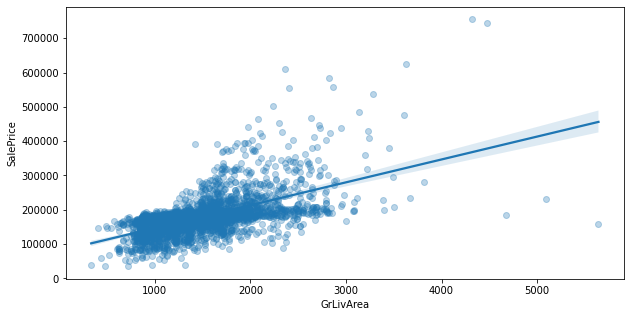

In [ ]:
# Verificar outliers
plt.figure(figsize=(10,5))
sns.regplot(df.GrLivArea, df.SalePrice, scatter_kws={'alpha':0.3})
plt.show()

A forma mais simples de lidar com os outlier é simplemente removê-los

In [ ]:
# Remover casas que tem mais que 4000 ft de area
df.drop(df[df.GrLivArea >= 4000].index, inplace = True)

### Adicionar atributos extras que podem ajudar a treinar o modelo

In [ ]:
# Somar a area da casa com a area da cave, juntando estes dois atributos
# Criar um attributo que diz a area total de todos os andares
# Criar um atribtuo que diz a area total das varandas
df['TotalSF'] = df.TotalBsmtSF + df.GrLivArea
df['TotalFloorSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df['ScreenPorch']

# Criar atributos do tipo booleano para obter parementros basicos da casa
df['HasBasement'] = df.TotalBsmtSF.apply(lambda x: 1 if x > 0 else 0)
df['HasGarage'] = df.GarageArea.apply(lambda x: 1 if x > 0 else 0)
df['HasPorch'] = df.TotalPorchSF.apply(lambda x: 1 if x > 0 else 0)
df['HasPool'] = df.PoolArea.apply(lambda x: 1 if x > 0 else 0)
df['WasRemodeled'] = (df.YearRemodAdd != df.YearBuilt).astype(np.int64)
df['IsNew'] = (df.YearBuilt > 2000).astype(np.int64)
df['WasCompleted'] = (df.SaleCondition != 'Partial').astype(np.int64)
df['TotalBathrooms'] = df.FullBath + .5 * df.HalfBath + df.BsmtFullBath + .5 * df.BsmtHalfBath

# Uma lista com todos os atributos booleanos
boolean_features = ['HasBasement', 'HasGarage', 'HasPorch', 'HasPool', 'WasRemodeled', 'IsNew', 'WasCompleted']

#esta divisão é para alterar porque todos os dados são numérico, mesmo as categorias
numeric_data = df.select_dtypes(include = [np.number])
categorical_data = df.select_dtypes(exclude = [np.number])
num_features = numeric_data.columns
cat_features = categorical_data.columns

print("Numéricas: {0}\nCategoriais: {1}".format(numeric_data.shape[1], categorical_data.shape[1]))

# Adiciona atributos que escaparam a lista criada anteriormente
num_features = [f for f in num_features if f not in boolean_features]

Numéricas: 93
Categoriais: 0


In [ ]:
features = num_features + ['SalePrice']
features.remove('ind')

# Normalizar
# np.log1p(x): Devolve o log(x + 1) (logaritomo natural)
for f in features:
  df.loc[:,f] = np.log1p(df[f])

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,TotalFloorSF,TotalPorchSF,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,TotalBathrooms
0,0.693147,4.110874,1.386294,4.189655,9.042040,0.693147,0.0,1.386294,1.386294,0.0,...,7.444833,4.127134,1,1,1,0,0,1,1,1.504077
1,1.098612,3.044522,1.386294,4.394449,9.169623,0.693147,0.0,1.386294,1.386294,0.0,...,7.141245,0.000000,1,1,0,0,0,0,1,1.252763
2,1.386294,4.110874,1.386294,4.234107,9.328212,0.693147,0.0,0.000000,1.386294,0.0,...,7.488294,3.761200,1,1,1,0,1,1,1,1.504077
3,1.609438,4.262680,1.386294,4.110874,9.164401,0.693147,0.0,0.000000,1.386294,0.0,...,7.448916,5.730100,1,1,1,0,1,0,1,1.098612
4,1.791759,4.110874,1.386294,4.442651,9.565284,0.693147,0.0,0.000000,1.386294,0.0,...,7.695758,4.442651,1,1,1,0,0,0,1,1.504077


Neste momento as categorias deixam de ser inteiros e passam a ser floats porque os datos estão em logaritmo. Esta transformação vai permitir obter melhores resultados no treino.

# **Modelo do treino**

O modelo de treino foi realizado em linear regression

In [ ]:
X_fully = df.copy()

y = X_fully[['SalePrice']]
#X_fully.drop('SalePrice', axis = 1, inplace = True)
X_fully.drop('Id', axis = 1 , inplace = True)
#X_fully.drop('ind', axis = 1 , inplace = True)

model_data = pd.get_dummies(X_fully).copy()

model_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,TotalFloorSF,TotalPorchSF,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,TotalBathrooms
0,4.110874,1.386294,4.189655,9.042040,0.693147,0.0,1.386294,1.386294,0.0,1.609438,...,7.444833,4.127134,1,1,1,0,0,1,1,1.504077
1,3.044522,1.386294,4.394449,9.169623,0.693147,0.0,1.386294,1.386294,0.0,1.098612,...,7.141245,0.000000,1,1,0,0,0,0,1,1.252763
2,4.110874,1.386294,4.234107,9.328212,0.693147,0.0,0.000000,1.386294,0.0,1.609438,...,7.488294,3.761200,1,1,1,0,1,1,1,1.504077
3,4.262680,1.386294,4.110874,9.164401,0.693147,0.0,0.000000,1.386294,0.0,0.000000,...,7.448916,5.730100,1,1,1,0,1,0,1,1.098612
4,4.110874,1.386294,4.442651,9.565284,0.693147,0.0,0.000000,1.386294,0.0,1.098612,...,7.695758,4.442651,1,1,1,0,0,0,1,1.504077


Dividir o data set em dois, um para treinar o modelo e outro para validar o modelo

In [ ]:
# Dividir a training data em dois data set diferentes, um para treinar e outro para validar
# o treino. Nao confundir com o data set de teste.
# x1_train - subconjunto do data set de treino utilizado para treinar o modelo
# y1_train - subconjunto do data set de treino utilizado para validar os paramnetros obtido atraves do treino de x1

#O valor 0.6931471805599453 é o log(1)
X_fully.ind=X_fully.ind.replace(0, "test")
#X_fully.ind=X_fully.ind.replace(0.6931471805599453, "train")
X_fully.ind=X_fully.ind.replace(1, "train")
x1_train, x1_test = X_fully[X_fully["ind"].eq("train")], X_fully[X_fully["ind"].eq("test")]


y1_train = x1_train[['SalePrice']]
y1_test = x1_test[['SalePrice']]

x1_train.drop("SalePrice", axis = 1, inplace = True)
x1_test.drop("SalePrice", axis = 1, inplace = True)

print('Shapes')
print('x1_train: ', x1_train.shape)
print('x1_test: ', x1_test.shape)
print('y1_train: ', y1_train.shape)
print('y1_test: ', y1_test.shape)

Shapes
x1_train:  (1456, 91)
x1_test:  (1458, 91)
y1_train:  (1456, 1)
y1_test:  (1458, 1)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
x1_train.drop('ind', axis = 1 , inplace = True)
x1_test.drop('ind', axis = 1 , inplace = True)


print('Shapes')
print('x1_train: ', x1_train.shape)
print('x1_test: ', x1_test.shape)
print('y1_train: ', y1_train.shape)
print('y1_test: ', y1_test.shape)

Shapes
x1_train:  (1456, 90)
x1_test:  (1458, 90)
y1_train:  (1456, 1)
y1_test:  (1458, 1)


Escalonar as features do data set de treino do modelo:

In [ ]:
num_features_1 = num_features.copy()
num_features_1.remove('ind')
num_features_1.remove('Id')
num_features_1.remove('SalePrice')

# Normalizar os atributos através da remoção da média e escalar em relação à variância da unidade
stdsc = StandardScaler()
x1_train.loc[:,num_features_1] = stdsc.fit_transform(x1_train[num_features_1])
x1_test.loc[:,num_features_1] = stdsc.transform(x1_test[num_features_1])


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [ ]:
def rsme(model, X, y):
  cv_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv = 10)
  return np.sqrt(cv_scores)


Utilização da ferramenta do lasso para determinar os coeficientes do modelo e apenas utilizar os mais relevantes

In [ ]:
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv = 5, param_grid = param_grid, scoring = 'neg_mean_squared_error')
lasso.fit(x1_train, y1_train)
alpha = lasso.best_params_['alpha']

print('1_ Lasso -> Train RSMF {:.5f} | Test RSME: {:.5f} | alpha: {:.5f}'.format(
      rsme(lasso, x1_train, y1_train).mean(), rsme(lasso, x1_test, y1_test).mean(), alpha))

param_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)], 'max_iter': [50000]}
lasso = GridSearchCV(Lasso(), cv = 5, param_grid = param_grid, scoring = 'neg_mean_squared_error')
lasso.fit(x1_train, y1_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print('2_ Lasso -> Train RSMF {:.5f} | Test RSME: {:.5f} | alpha: {:.5f}'.format(
      rsme(lasso, x1_train, y1_train).mean(), rsme(lasso, x1_test, y1_test).mean(), alpha))


1_ Lasso -> Train RSMF 0.00925 | Test RSME: 0.00154 | alpha: 0.00010
2_ Lasso -> Train RSMF 0.00924 | Test RSME: 0.00160 | alpha: 0.00015


Verificar se os coeficientes utilizados são aqueles que têm mais impacto

LASSO dropped 30 of 90 features


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


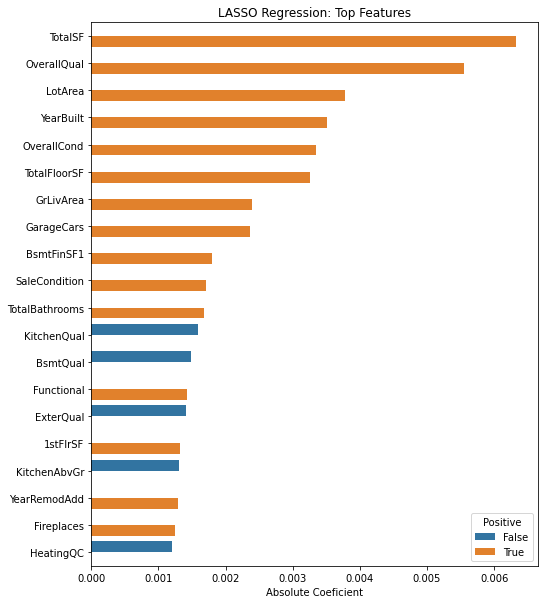

In [ ]:
coefs = pd.DataFrame({'coefs': lasso.coef_, 'Positive': lasso.coef_ > 0}, index = x1_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)

print('LASSO dropped {} of {} features'.format(sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending = False).head(20)
plt.figure(figsize = (8, 10))
sns.barplot(top_coefs.coefs_abs, top_coefs.index, orient = 'h', hue = top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

Utilização da ferramenta XGBoost para aumentar a eficácia do modelo

In [ ]:
regr = xgb.XGBRegressor(colsample_bytree = 0.2,
                        gamma = 0.0,
                        learning_rate = 0.07,
                        max_depth = 6,
                        min_child_weight = 1.5,
                        n_estimators = 7200,
                        reg_alpha = 0.9,
                        reg_lambda = 0.6,
                        subsample = 0.2,
                        seed = 42,
                        silent = 1)

regr.fit(x1_train[top_coefs.index], y1_train)

XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.07, max_depth=6,
             min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9,
             reg_lambda=0.6, seed=42, silent=1, subsample=0.2)

# **Resultado**

Previsão dos preços da casa do data set de validação

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))


y_pred = regr.predict(x1_test[top_coefs.index])


print("XGBoost score on testing set: ", rmse(y1_test, y_pred))

XGBoost score on testing set:  0.024094291089894346
